# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

homeo_method = 'HEH'
tag = 'autoencoder'
tag = 'independance'

matname = tag +'_' + homeo_method

nb_quant = 128
nb_quant = 256
C = 5.
eta_homeo=0.05
alpha_homeo=0.02
do_double_shuffle = True
do_double_shuffle = False
do_random = True

n_iter = 2**13 + 1

record_num_batches = 2**11
N_show = 120
max_patches = 10
seed = 42
np.random.seed(seed)

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            homeo_method=homeo_method, eta_homeo=eta_homeo, alpha_homeo=alpha_homeo, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)


In [4]:
from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname=tag)

Extracting data..loading the data called : data_cache/independance_data
Data is of shape : (81920, 144) - done in 0.05s.


In [5]:
!ls -l {shl.data_cache}/{tag}*
!rm -fr {shl.data_cache}/{tag}*lock*

-rw-r--r--  1 lolo  staff   2533678 Feb 20 15:12 data_cache/independance_HEH_dico.pkl
-rw-r--r--  1 lolo  staff   2533679 Feb 20 16:24 data_cache/independance_None_dico.pkl
-rw-r--r--  1 lolo  staff  94371968 Feb 20 12:17 data_cache/independance_data.npy


In [6]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 144)
average of patches =  1.274788766001906e-05  +/-  0.008208904871778732
average energy of data =  0.05934010035972646 +/- 0.06825018408240678


In [7]:
l0_sparseness = shl.l0_sparseness
l0_sparseness_noise = 200 #shl.n_dictionary #
#l0_sparseness_high = shl.l0_sparseness * 2
shl.do_precision

False

In [8]:
stick = np.arange(shl.n_dictionary)*nb_quant

indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

loading the dico called : data_cache/independance_HEH_dico.pkl


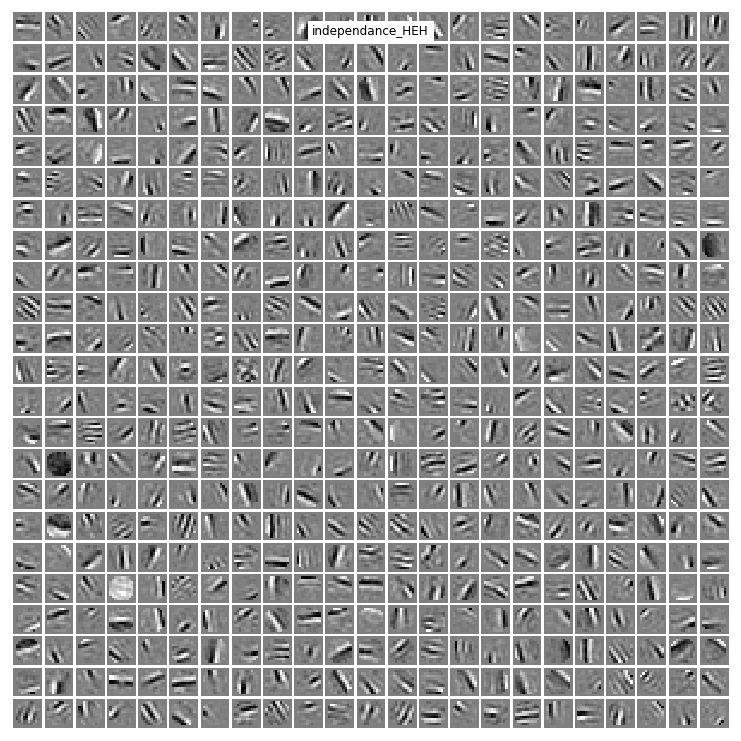

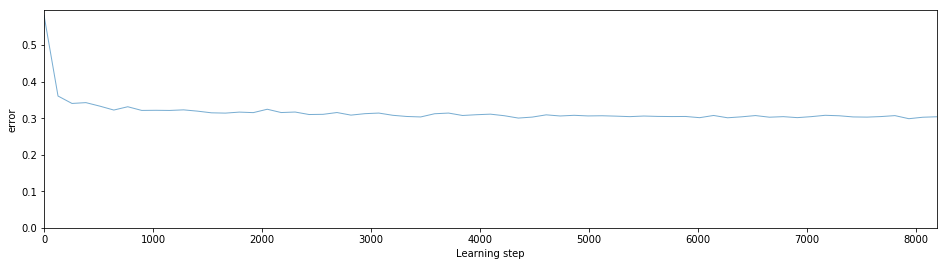

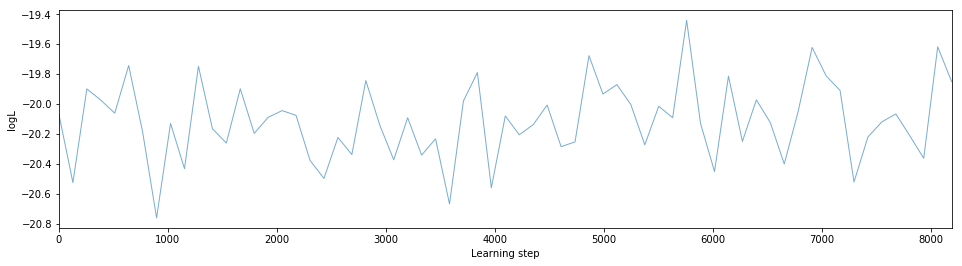

In [9]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL']

dico_homeo = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico_homeo.dictionary.shape)
print('average of filters = ',  dico_homeo.dictionary.mean(axis=1).mean(), 
      '+/-',  dico_homeo.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico_homeo.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  0.0001661485290286474 +/- 0.008758877783279759
average energy of filters =  1.0 +/- 8.34676118839486e-17


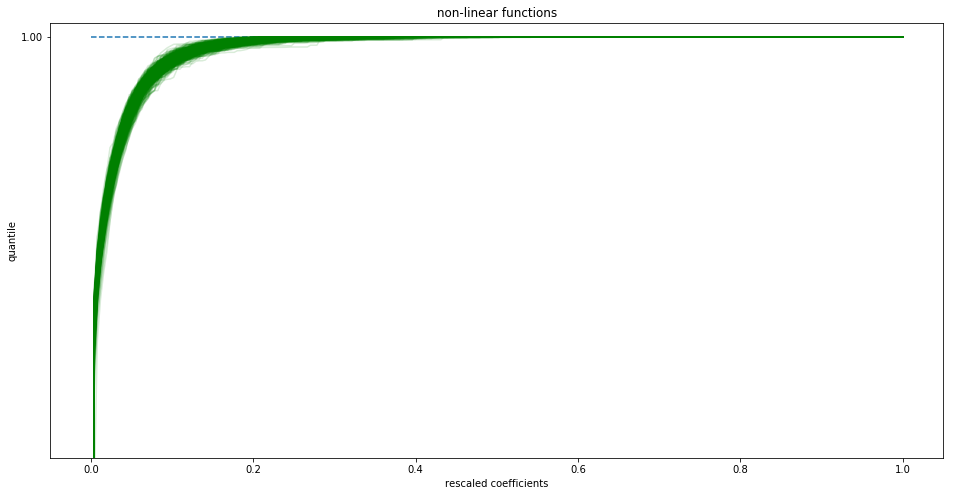

In [11]:
if not dico_homeo.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico_homeo.P_cum, verbose=False, alpha=.15);
    ax.set_ylim(0.97, 1.001)
    #ax.set_xmargin(0.);

## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [12]:
from shl_scripts.shl_tools import show_data
def print_stats(data, dictionary, sparse_code):
    print(42*'🐒')
    patches = sparse_code @ dictionary
    error = data - patches

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

    print('number of codes, size of reconstructed images = ', patches.shape)

    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[:max_patches, :])
    plt.show()
    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data**2, axis=1))
    #SD = np.linalg.norm(data[indx, :])/record_num_batches

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    #print('total energy of data = ', np.sqrt(np.sum(data**2)))
    #print('total deviation of data = ', np.sum(np.abs(data)))
    
    SE = np.sqrt(np.mean(error**2, axis=1))
    #SE = np.linalg.norm(error)/record_num_batches

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
    #print('total deviation of residual = ', np.sum(np.abs(error)))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    #print('average gain of coding = ', data[indx, :].std()/error.std())  
    
    return SD, SE

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004004049047779668
average std of codewords =  0.04410418667523537
l0-sparseness of codewords =  0.028306467095935726  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0010737616577241467
number of codes, size of reconstructed images =  (2048, 144)


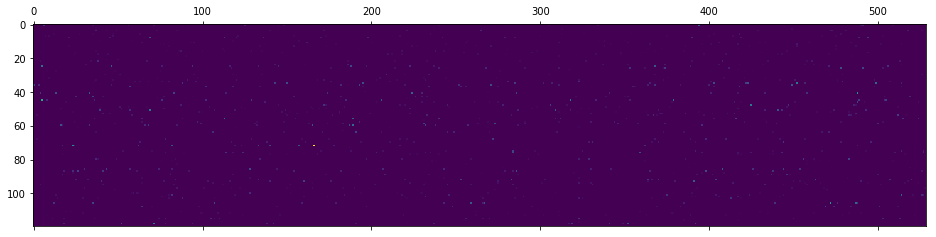

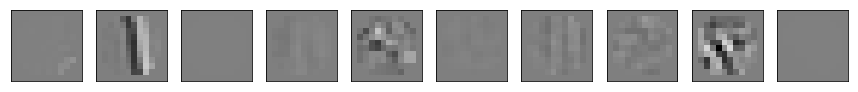

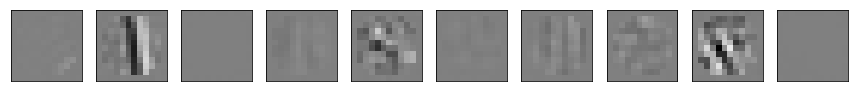

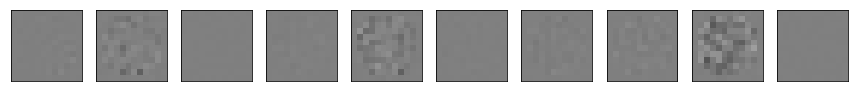

average of data patches =  8.645923389323598e-05 +/- 0.007589220242732098
average of residual patches =  -4.117920048657338e-06 +/- 0.0022175270279023145
median energy of data =  0.028980042378636613
average energy of data =  0.05700159151318996 +/- 0.06799758198001712
average energy of residual =  0.016852171405102697 +/- 0.01974810370711371
median energy of residual =  0.008972573413106338
average gain of coding =  3.876207155388776 +/- 1.4853899940990025
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004004049047779668
average std of codewords =  0.04410418667523538
l0-sparseness of codewords =  0.028306467095935726  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0010737616577241467
number of codes, size of reconstructed images =  (2048, 144)


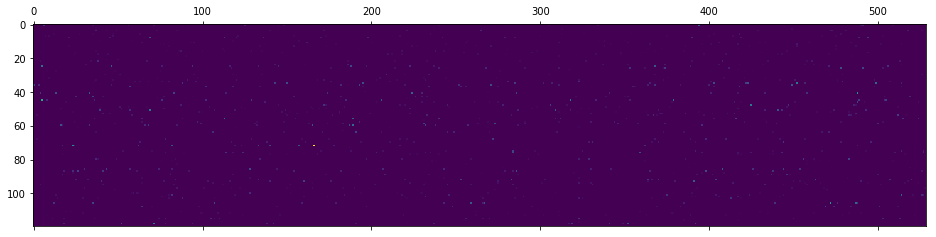

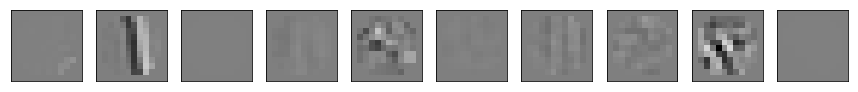

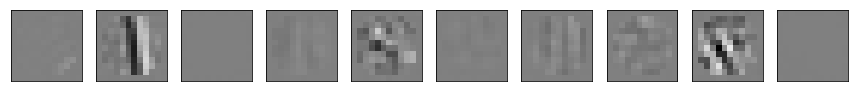

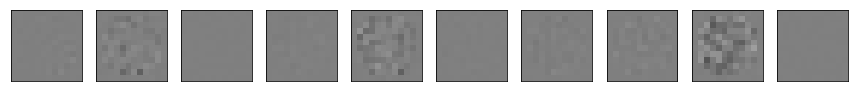

average of data patches =  8.645923389323598e-05 +/- 0.007589220242732098
average of residual patches =  -4.1179200486571035e-06 +/- 0.0022175270279023145
median energy of data =  0.028980042378636613
average energy of data =  0.05700159151318996 +/- 0.06799758198001712
average energy of residual =  0.016852171405102694 +/- 0.01974810370711371
median energy of residual =  0.008972573413106337
average gain of coding =  3.8762071553887765 +/- 1.4853899940990027
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004022884194989239
average std of codewords =  0.04390399318249263
l0-sparseness of codewords =  0.02828616050330813  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.001402596225627492
number of codes, size of reconstructed images =  (2048, 144)


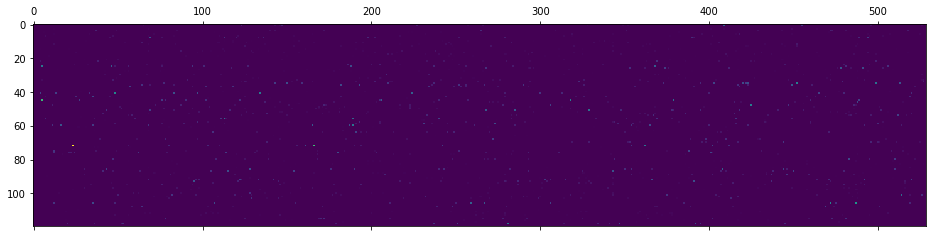

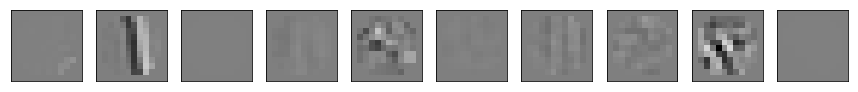

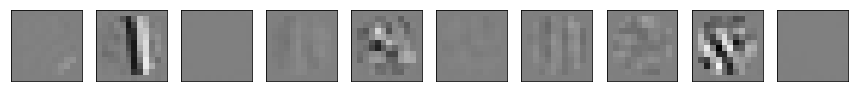

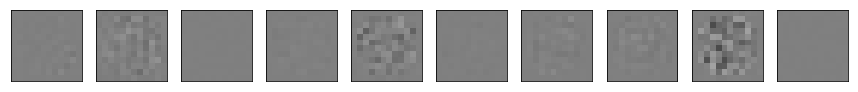

average of data patches =  8.645923389323598e-05 +/- 0.007589220242732098
average of residual patches =  -0.00021631855454467533 +/- 0.00272294568769817
median energy of data =  0.028980042378636613
average energy of data =  0.05700159151318996 +/- 0.06799758198001712
average energy of residual =  0.0177950008073377 +/- 0.020577345525435154
median energy of residual =  0.009967812569802451
average gain of coding =  3.7064429569691137 +/- 1.528192344500192


In [13]:
from shl_scripts.shl_encode import sparse_encode
if dico_homeo.P_cum is None: 
    gain = np.ones(shl.n_dictionary)
else:
    gain = None
dico_rec = dico_homeo.dictionary

for P_cum_rec, gain_rec in zip([None, P_cum_zeroeffect, dico_homeo.P_cum], [np.ones(shl.n_dictionary), None, gain]):
    sparse_code = sparse_encode(data[indx, :], dico_rec, P_cum=P_cum_rec, C=C, 
                                 l0_sparseness=l0_sparseness, gain=gain_rec)   

    SD, SE = print_stats(data[indx, :], dico_homeo.dictionary, sparse_code)

## Generating new coefficients by shuffling and decoding

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [ 57  35  89  43  65  58  54  67  29  75  48  75  58  38  48  77  24  89
  46  31  47  53  61  55  65  68  20  35  63  60  80  45  76  74  53  38
  36  46  36  26  17  67  69  51  44  44  33  55  27  65  73  35  24  38
  62  38  56  66  45  57  59  29  50  59 104  46  44  54  97  65  60  79
  39  66  31  51 112  49  57  79  31  33  41  79 110  64  92  

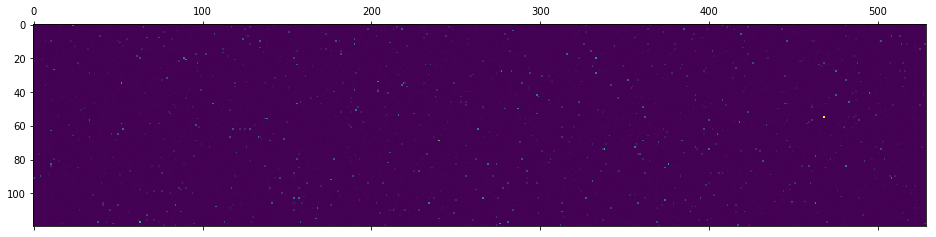

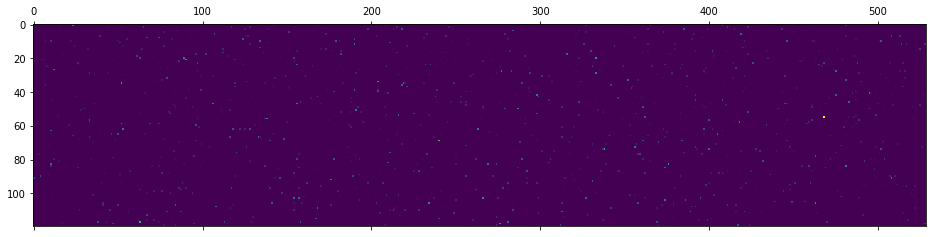

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [56 57 71 58 56 44 42 55 61 59 60 47 60 65 64 53 68 56 35 62 49 68 51 57
 58 49 57 55 56 66 48 49 53 68 67 72 57 61 71 52 61 59 52 66 62 63 68 50
 54 60 60 42 61 61 62 67 51 40 56 74 42 49 60 65 57 53 52 52 53 55 54 55
 67 54 51 48 68 55 65 60 66 70 50 55 60 42 67 56 63 55 65 47 60 58 63 56
 53 61 66 46 52 56 64 56 52 45 61 50 54 40 55 51 64 59 52 50 6

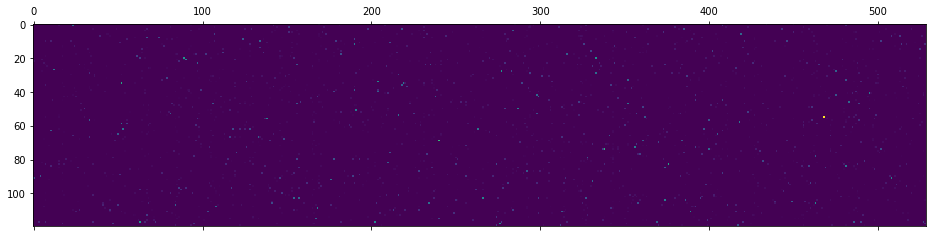

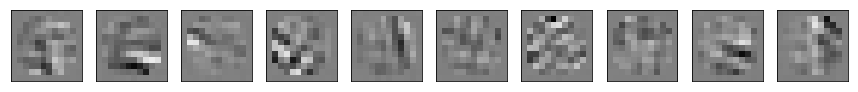

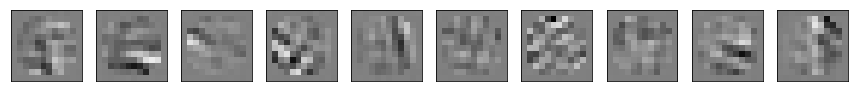

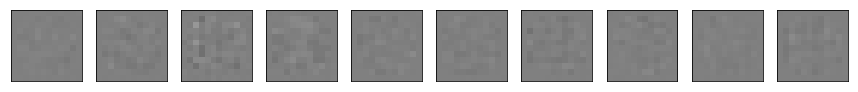

average of data patches =  0.001063138680339482 +/- 0.008495578626584847
average of residual patches =  0.00017733869209466364 +/- 0.0014042001283659047
median energy of data =  0.07045658005357017
average energy of data =  0.07741448962537861 +/- 0.037394367020431515
average energy of residual =  0.009631977653998628 +/- 0.004877388027779975
median energy of residual =  0.008162038222446714
average gain of coding =  8.68826192777614 +/- 4.2338656680407984


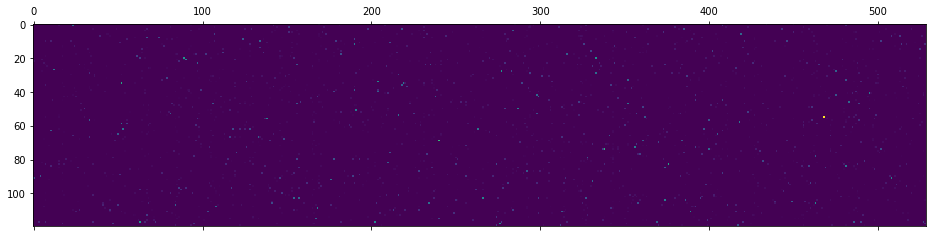

mean deviation of coefficients =  0.013824979820515448 0.004351378375585979 0.004410307256607314
total deviation of coefficients =  0.0028307171133707615
mean deviation of quantiles =  0.007214268835511229
mean deviation of quantiles =  0.007159006916635606
total deviation of quantiles =  0.009001192773002329
ratio deviation of quantiles =  1.247693006489475
proba incorrect coefficients =  0.9719538265004726
proba incorrect coefficients (strong) =  0.03561684044187141


In [14]:
def shuffling(data, sparse_code, dico):
    if do_random:
        from shl_scripts.shl_encode import inv_quantile, inv_rescaling
        sparse_code_bar = inv_rescaling(inv_quantile(dico.P_cum, np.random.rand(sparse_code.shape[0], sparse_code.shape[1])), C=C)
    else:
        sparse_code = sparse_encode(data, dico.dictionary, P_cum=dico.P_cum, C=C, 
                                     l0_sparseness=l0_sparseness_noise, gain=None)   

        sparse_code_bar = sparse_code.copy()
        
        sparse_code_bar = sparse_code_bar.T
        np.random.shuffle(sparse_code_bar)
        sparse_code_bar = sparse_code_bar.T
        
        if do_double_shuffle:
            np.random.shuffle(sparse_code_bar)


    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code, axis=0)[:N_show])

    print(sparse_code_bar.shape)

    plt.matshow(sparse_code_bar[:N_show, :])
    plt.show()

    def threshold(sparse_code, l0_sparseness):
        thr = np.percentile(sparse_code, 100 * (1 - l0_sparseness/shl.n_dictionary ), axis=1)
        return (sparse_code>thr[:, np.newaxis])

    sparse_code_bar_high = threshold(sparse_code_bar, l0_sparseness) * sparse_code_bar
    plt.matshow(sparse_code_bar_high[:N_show, :])
    plt.show()
    return sparse_code_bar, sparse_code_bar_high

def pipeline(sparse_code_bar, sparse_code_bar_high, dico, index):

    patches_bar = sparse_code_bar @ dico.dictionary
    SD = np.sqrt(np.mean(patches_bar**2, axis=1))


    P_cum_rec = dico.P_cum
    if P_cum_rec is None: 
        gain_rec = np.ones(shl.n_dictionary)
    else:
        gain_rec = None

    sparse_code_rec = sparse_encode(patches_bar, dico.dictionary, P_cum=P_cum_rec, C=C, 
                                     l0_sparseness=l0_sparseness, gain=gain_rec)   

    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_bar_high, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_rec, axis=0)[:N_show])
    
    
    SD, SE = print_stats(patches_bar, dico.dictionary, sparse_code_rec)
    
    plt.matshow(sparse_code_rec[:N_show, :])
    plt.show()

    print('mean deviation of coefficients = ', np.mean(np.abs(sparse_code_bar)), np.mean(np.abs(sparse_code_bar_high)), np.mean(np.abs(sparse_code_rec)))
    print('total deviation of coefficients = ', np.mean(np.abs(sparse_code_bar_high-sparse_code_rec)))

    if not dico.P_cum is None: 
        from shl_scripts.shl_encode import quantile, rescaling

        q_rec = quantile(dico.P_cum, rescaling(sparse_code_rec, C=C), stick, do_fast=False)
        q_bar = quantile(dico.P_cum, rescaling(sparse_code_bar_high, C=C), stick, do_fast=False)

        print('mean deviation of quantiles = ', np.mean(np.abs(q_bar)))
        print('mean deviation of quantiles = ', np.mean(np.abs(q_rec)))
        print('total deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec)))
        print('ratio deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar)))
        aerror = np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar))
    else:
        aerror = np.nan

    perror = 1 - np.mean( (sparse_code_bar>0) == (sparse_code_rec>0))
    print('proba incorrect coefficients = ', perror)

    perror_high = 1 - np.mean( (sparse_code_bar_high > 0) == (sparse_code_rec>0))
    print('proba incorrect coefficients (strong) = ', perror_high)
    
    return pd.DataFrame({'error':[(SD/SE).mean()],
                               'aerror':[aerror],
                               'perror':[perror],
                               'perror_high':[perror_high]
                                        },
                                index=[index])

sparse_code_bar, sparse_code_bar_high = shuffling(data[indx, :], sparse_code, dico_homeo)
record = pipeline(sparse_code_bar, sparse_code_bar_high, dico_homeo, index='homeo')

In [15]:
record

,aerror,error,perror,perror_high
homeo,1.247693,8.688262,0.971954,0.035617


## comparing to the learning without homeostasis

Extracting data..loading the data called : data_cache/independance_data
Data is of shape : (81920, 144) - done in 0.05s.
loading the dico called : data_cache/independance_None_dico.pkl


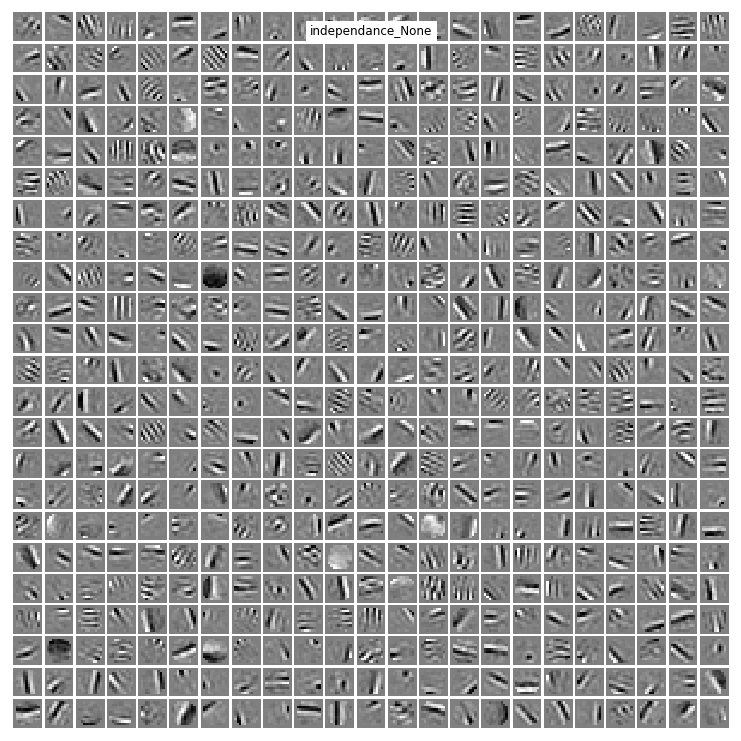

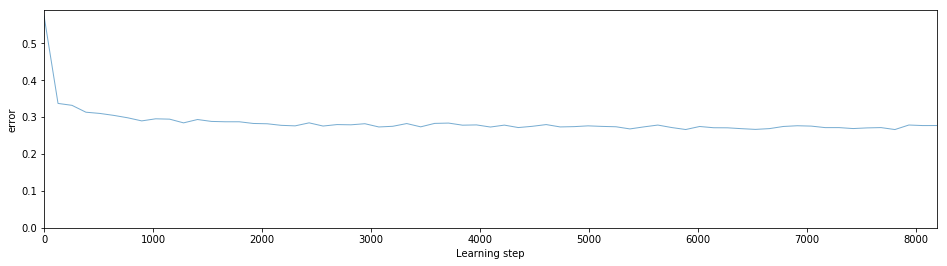

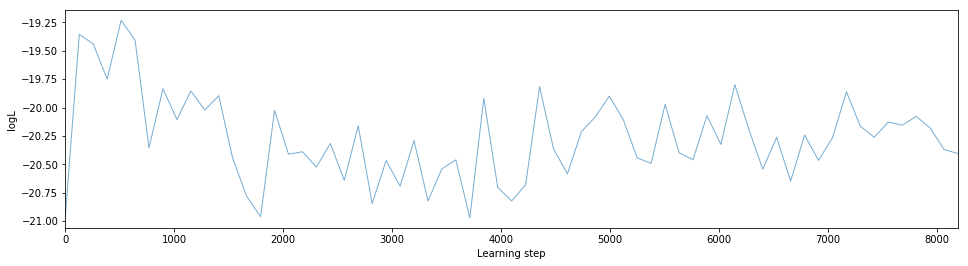

In [16]:
homeo_method = 'None'
matname = tag + '_' + homeo_method

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            homeo_method=homeo_method, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)

from shl_scripts.shl_experiments import SHL
shl_nohomeo = SHL(**opts)
data = shl_nohomeo.get_data(matname=tag)
dico_nohomeo = shl_nohomeo.learn_dico(data=data, list_figures=list_figures, matname=matname)

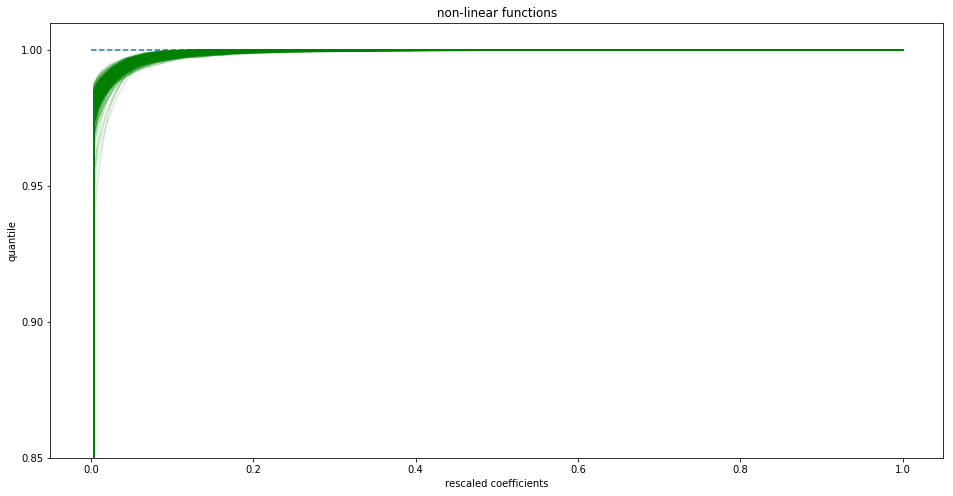

In [17]:
if not dico_nohomeo.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico_nohomeo.P_cum, verbose=False, alpha=.15);
    ax.set_ylim(0.85, 1.01)
    #ax.set_xmargin(0.);

### coding


🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004012364673143294
average std of codewords =  0.04438888813348405
l0-sparseness of codewords =  0.028312928284499054  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0012305424353247255
number of codes, size of reconstructed images =  (2048, 144)


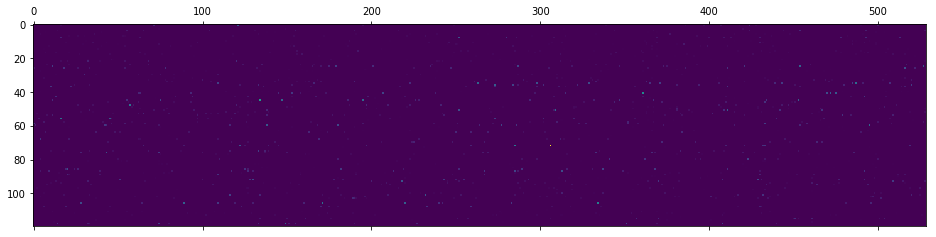

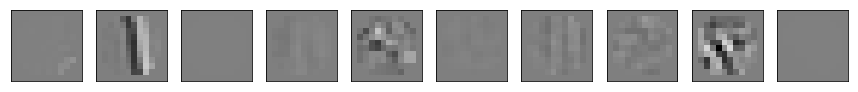

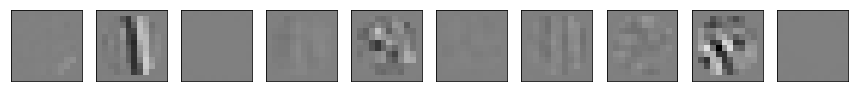

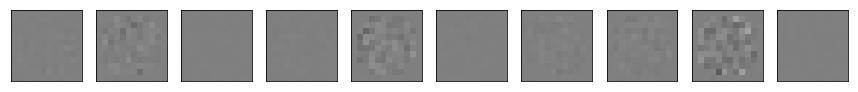

average of data patches =  8.645923389323598e-05 +/- 0.007589220242732098
average of residual patches =  1.339606562076588e-05 +/- 0.002193485258252549
median energy of data =  0.028980042378636613
average energy of data =  0.05700159151318996 +/- 0.06799758198001712
average energy of residual =  0.015931190377523927 +/- 0.018256504890409093
median energy of residual =  0.00863691264724874
average gain of coding =  3.997685665175656 +/- 1.460776693352349


(array([0.0084, 0.089 , 0.0004, ..., 0.0885, 0.0498, 0.0008]),
 array([0.0034, 0.0138, 0.    , ..., 0.0247, 0.0117, 0.0002]))

In [18]:
P_cum_rec = None 
gain_rec = np.ones(shl_nohomeo.n_dictionary)
dico_rec = dico_nohomeo.dictionary

sparse_code = sparse_encode(data[indx, :], dico_rec, P_cum=P_cum_rec, C=C, 
                                 l0_sparseness=l0_sparseness, gain=gain_rec)   

print_stats(data[indx, :], dico_nohomeo.dictionary, sparse_code)

### Generating and shuffling the coefficients

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [56 57 71 58 56 44 42 55 61 59 60 47 60 65 64 53 68 56 35 62 49 68 51 57
 58 49 57 55 56 66 48 49 53 68 67 72 57 61 71 52 61 59 52 66 62 63 68 50
 54 60 60 42 61 61 62 67 51 40 56 74 42 49 60 65 57 53 52 52 53 55 54 55
 67 54 51 48 68 55 65 60 66 70 50 55 60 42 67 56 63 55 65 47 60 58 63 56
 53 61 66 46 52 56 64 56 52 45 61 50 54 40 55 51 64 59 52 50 6

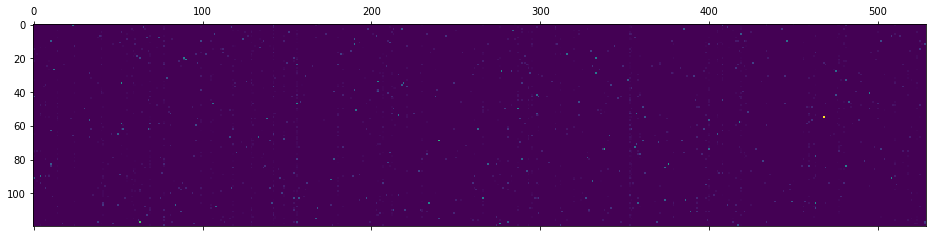

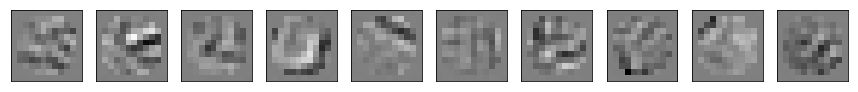

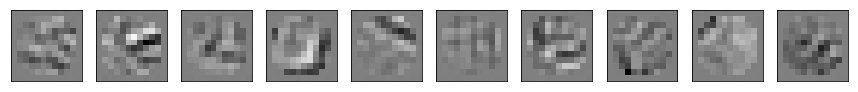

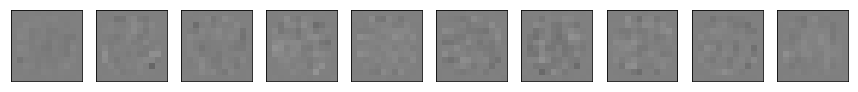

average of data patches =  0.0007102016960096971 +/- 0.009790214004415165
average of residual patches =  -9.631795640493129e-06 +/- 0.0023169258600809575
median energy of data =  0.07030914006403699
average energy of data =  0.07719355752671103 +/- 0.037303644397833666
average energy of residual =  0.015103056711320586 +/- 0.006695692788759752
median energy of residual =  0.013643028977573616
average gain of coding =  5.5276245644771755 +/- 2.8290293564470077


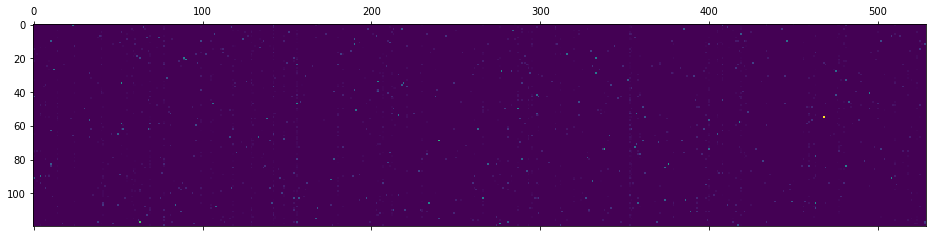

mean deviation of coefficients =  0.013824979820515448 0.004351378375585979 0.004369691431630043
total deviation of coefficients =  0.003576901647278685
mean deviation of quantiles =  0.007215558209394354
mean deviation of quantiles =  0.006992330039175749
total deviation of quantiles =  0.010233730145174355
ratio deviation of quantiles =  1.4182866866558526
proba incorrect coefficients =  0.9725417946597353
proba incorrect coefficients (strong) =  0.04014982573251413


,aerror,error,perror,perror_high
homeo,1.247693,8.688262,0.971954,0.035617
nohomeo,1.418287,5.527625,0.972542,0.040150


In [19]:
pd.concat([record, pipeline(sparse_code_bar, sparse_code_bar_high, dico_nohomeo, index='nohomeo')])

## Version used

In [20]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.0
shl_scripts 20171221
pandas 0.22.0
Wed Feb 21 10:07:22 2018 CET